In [1]:
import sys
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    classification_report,
)


# Local module imports
sys.path.insert(0, "..") # adds parent folder to sys path

from models.chatbot_model import ChatbotModel

In [2]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data["Sentence"] = data["Sentence"].str.lower()
    data["Sentence"] = data["Sentence"].replace(
        "[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+", "", regex=True
    )  # remove emails
    data["Sentence"] = data["Sentence"].replace(
        "((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}", "", regex=True
    )  # remove IP address
    data["Sentence"] = data["Sentence"].str.replace(
        "[^\w\s]", ""
    )  # remove special characters
    data["Sentence"] = data["Sentence"].replace("\d", "", regex=True)  # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row["Sentence"])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words("english")]
        df_ = df_.append(
            {
                "index": row["index"],
                "Class": row["Class"],
                "Sentence": " ".join(filtered_sent[0:]),
            },
            ignore_index=True,
        )
    return data

In [12]:
DATASET_PATH = "../datasets/amazon_cells_labelled.txt"

# get data, pre-process and split
data = pd.read_csv(DATASET_PATH, delimiter="\t", header=None)
print(data)
data.columns = ["Sentence", "Class"]
data["index"] = data.index  # add new column index
columns = ["index", "Class", "Sentence"]
print(data)
data = preprocess_pandas(data, columns)  # pre-process
(training_data, test_data, training_labels, test_labels) = train_test_split(  # split the data into training, validation, and test splits
    data["Sentence"].values.astype("U"),
    data["Class"].values.astype("int32"),
    test_size=0.10,
    random_state=0,
    shuffle=True,
)

(training_data, validation_data, training_labels, validation_labels) = train_test_split(
    training_data,
    training_labels,
    test_size=0.10,
    random_state=0, 
    shuffle=True
)

# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    max_features=50000,
    max_df=0.5,
    use_idf=True,
    norm="l2",
)
training_data = word_vectorizer.fit_transform(training_data)  # transform texts to sparse matrix
training_data = training_data.todense()  # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)

validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()

test_data = word_vectorizer.transform(test_data)
test_data = test_data.todense()

train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()

validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

test_x_tensor = torch.from_numpy(np.array(test_data)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(test_labels)).long()

                                                     0  1
0    So there is no way for me to plug it in here i...  0
1                          Good case, Excellent value.  1
2                               Great for the jawbone.  1
3    Tied to charger for conversations lasting more...  0
4                                    The mic is great.  1
..                                                 ... ..
995  The screen does get smudged easily because it ...  0
996  What a piece of junk.. I lose more calls on th...  0
997                       Item Does Not Match Picture.  0
998  The only thing that disappoint me is the infra...  0
999  You can not answer calls with the unit, never ...  0

[1000 rows x 2 columns]
                                              Sentence  Class  index
0    So there is no way for me to plug it in here i...      0      0
1                          Good case, Excellent value.      1      1
2                               Great for the jawbone.      1      2
3  

In [4]:
# Combine data with labels
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
validation_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

trainloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validationloader = DataLoader(validation_dataset, batch_size=len(validation_data), shuffle=False)
testloader = DataLoader(test_dataset, batch_size=len(test_data), shuffle=False)

print(f"Training size={len(train_dataset)}")
print(f"Validation size={len(validation_dataset)}")
print(f"Test size={len(test_dataset)}")

Training size=810
Validation size=90
Test size=100


In [5]:
classes = {"negative": 0, "positive": 1} # The classes of the labeled dataset

Epoch 10 [81/81] - Loss: 0.13634976744651794

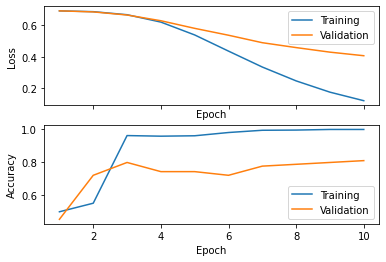

In [6]:
# Use the model defined in ./models/chatbot_model.py
network = ChatbotModel(vocab_size=vocab_size, vectorizer=word_vectorizer)

optimizer = torch.optim.Adam(network.parameters(), lr=0.0001, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss()

epochs = 10

validation_loss = []
training_loss = []

training_accuracy = []
validation_accuracy = []

for epoch in range(epochs):
    validation_loss_epoch = 0
    training_loss_epoch = 0
    training_batches = 0
    validation_batches = 0
    
    training_correct_epoch = 0
    training_total_epoch = 0
    validation_correct_epoch = 0
    validation_total_epoch = 0
    
    for batch_nr, (data, labels) in enumerate(trainloader):
        training_batches += 1
        prediction = network(data)
        loss = loss_function(prediction, labels)
        
        training_loss_epoch += loss.item()
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        # Collect training accuracy statistics
        prediction = list(pred.argmax() for pred in prediction)
        training_correct_epoch += np.equal(prediction, labels).sum().item()
        training_total_epoch += len(labels)
        
        #Print the epoch, batch, and loss
        print(
            f'\rEpoch {epoch+1} [{batch_nr+1}/{len(trainloader)}] - Loss: {loss}',
            end=''
        )
        
    for batch_nr, (data, labels) in enumerate(validationloader):
        with torch.no_grad():
            validation_batches += 1
            prediction = network(data)
            loss = loss_function(prediction, labels)
            validation_loss_epoch += loss.item()
            
            # Collect validation accruacy statistics
            prediction = list(pred.argmax() for pred in prediction)
            validation_correct_epoch += np.equal(prediction, labels).sum().item()
            validation_total_epoch += len(labels)
        
    # Store loss for plot
    avr_training_loss = training_loss_epoch/training_batches
    avr_validation_loss = validation_loss_epoch/validation_batches
    training_loss.append(avr_training_loss)
    validation_loss.append(avr_validation_loss)
    
    # Store accuracy for plot
    training_accuracy.append(training_correct_epoch / training_total_epoch)
    validation_accuracy.append(validation_correct_epoch / validation_total_epoch)


fig, (plt_loss, plt_accuracy) = plt.subplots(2, sharex=True)
plt_loss.plot(range(1, len(training_loss)+1), training_loss, label="Training")
plt_loss.plot(range(1, len(validation_loss)+1), validation_loss, label="Validation")
plt_loss.set_xlabel('Epoch')
plt_loss.set_ylabel('Loss')
plt_loss.legend()

plt_accuracy.plot(range(1, len(training_accuracy)+1), training_accuracy, label="Training")
plt_accuracy.plot(range(1, len(validation_accuracy)+1), validation_accuracy, label="Validation")
plt_accuracy.set_xlabel('Epoch')
plt_accuracy.set_ylabel('Accuracy')
plt_accuracy.legend()

In [7]:
correct = 0
total = 0

# Test accuracy
for batch_nr, (data, labels) in enumerate(testloader):
    predictions = network.predict(data)

    # Sum all the predictions that were the same as the label
    correct += np.equal(predictions, labels).sum().item()
    total += len(labels)

print(f'The accuracy of the network on the test data is {str(100*correct/total)[:4]}%. total={total} correct={correct}')

The accuracy of the network on the test data is 81.0%. total=100 correct=81


In [ ]:
# Let's print a sentence and predict it's category
str_input = "jjjjjjj"
prediction = network.predict_str(str_input)
prediction = "positive" if prediction == classes["positive"] else "negative"
print(f"The input '{str_input}' is {prediction}")

In [9]:
#save_model(network, "ann-model-amazon")
network.save_model()